## Importando bibliotecas

In [3]:
# caso precise utilizar GPU
# https://www.youtube.com/watch?v=ryFFCyhTgyA
# !pip install tensorflow-gpu==2.10.0
# 
# import subprocess
# command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# output = subprocess.check_output(command, shell=True, encoding='utf-8')
# for idx, line in enumerate(output.splitlines()):
#     name, memory = line.strip().split(',')
#     print(f"GPU {idx} - Nome {name}, Memória total: {memory} MB")

GPU 0 - Nome NVIDIA GeForce GTX 1080, Memória total:  8192 MB



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# comentar esta linha caso use GPU
!pip install tensorflow

!pip install pandas yfinance matplotlib scikit-learn joblib pytz python-dateutil pmdarima keras-tuner "numpy<2"



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
#from reportlab.rl_settings import verbose
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
import tensorflow as tf

import joblib as jl

from pmdarima import auto_arima
import warnings

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

## Métodos auxiliares

In [29]:
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

def show_history_details(ticker_history: DataFrame) -> None:
    print(f"Tamanho: {len(ticker_history)}")
    print(f"Data min: {ticker_history.index.min()}")
    print(f"Data max: {ticker_history.index.max()}")


def filter_per_date(history: DataFrame, min_date, max_date) -> DataFrame:
    return history[(history.index >= min_date) & (history.index <= max_date)]


def get_first(dict_tickers_history: dict):
    return next(iter(dict_tickers_history.values()))


def show_dict_tickers_history_details(dict_tickers_history: dict) -> None:
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  print("Detalhes do primeiro ticker")
  show_history_details(get_first(dict_tickers_history))
  
  
def show_first_ticker_period_details(dict_periods: dict) -> None:
    for periodo, dict_tickers in dict_periods.items():
        first_ticker = get_first(dict_tickers)
        print(f"Período: {periodo}")
        print(f"NumDiffs: {first_ticker['num_diffs']}")
        print(f"ScalerNormalizacao: (Min: {first_ticker['scaler_normalizacao'].data_min_} - Max: {first_ticker['scaler_normalizacao'].data_max_})")
        display(first_ticker["history"].head())
        print("")


def show_first_ticker_pred_results(dict_pred_periods: dict) -> None:
    for periodo, dict_tickers in dict_pred_periods.items():
        first_ticker = get_first(dict_tickers)
        print(f"Período: {periodo}")
        display(first_ticker.head())
        print("")


def plot_first_ticker_model_results(dict_arima_pred_results: dict, dict_train_periods: dict, dict_test_history: dict, dict_train_history: dict):
    for periodo, dict_tickers in dict_arima_pred_results.items():
        pred_history = get_first(dict_tickers)["PredCloseRevertido"]
        train_history = get_first(dict_train_periods[periodo])["history"]["Close"]
        test_history = get_first(dict_test_history)["Close"]
        plot_model_results(train_history, test_history, pred_history, all_train_history=get_first(dict_train_history)["Close"], titulo=f"Previsão com {periodo} de treino")
        

def plot_model_results(train_history: pd.Series, test_history: pd.Series, pred_history: pd.Series, all_train_history: pd.Series, titulo: str) -> None:
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    treino_nao_utilizado = all_train_history.drop(train_history.index)
    plt.plot(treino_nao_utilizado.index, treino_nao_utilizado.values, label="Treino não utilizado")
    plt.plot(train_history.index, train_history.values, label='Treino utilizado')
    plt.plot(test_history.index, test_history.values, label='Teste')
    plt.plot(pred_history.index, pred_history.values, label='Previsto')
    plt.plot()
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title(titulo)
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

## Seleção das ações

Para pegar os nomes das ações listadas na B3, fizemos o download de um csv no https://www.dadosdemercado.com.br/acoes.

In [7]:
def get_b3_ticker_symbols() -> list:
    """
    download do csv nesse link: https://www.dadosdemercado.com.br/acoes
    """
    tickers_df = pd.read_csv('acoes-listadas-b3.csv')
    return tickers_df['Ticker'].tolist()

lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3', 'B3SA3', 'HAPV3', 'PETR4', 'ENEV3', 'EMBR3', 'ITUB4', 'AZUL4', 'BBDC4', 'ABEV3', 'ITSA4', 'ASAI3', 'COGN3', 'PETZ3', 'PETR3', 'VALE3', 'BBAS3', 'CPLE6', 'RDOR3', 'CSAN3', 'STBP3', 'MGLU3', 'CMIG4', 'GGBR4', 'IFCM3', 'POMO4', 'CXSE3', 'ELET3', 'RENT3', 'RAIL3', 'WEGE3', 'CMIN3', 'VBBR3', 'CVCB3', 'CCRO3', 'UGPA3', 'TIMS3', 'NTCO3', 'RAIZ4', 'QUAL3', 'EQTL3', 'RADL3', 'JBSS3', 'USIM5', 'FLRY3', 'CSNA3', 'SUZB3', 'CRFB3', 'AMER3', 'RRRP3', 'CPLE3', 'AURE3', 'BBDC3', 'HBSA3', 'DXCO3', 'BEEF3', 'SBSP3', 'PRIO3', 'BBSE3', 'BRFS3', 'ONCO3', 'ALOS3', 'MRVE3', 'PCAR3', 'YDUQ3', 'GOLL4', 'GGPS3', 'VAMO3', 'MLAS3', 'TOTS3', 'AZEV4', 'VVEO3', 'BHIA3', 'HYPE3', 'ECOR3', 'CYRE3', 'GOAU4', 'BRKM5', 'VIVT3', 'VIVA3', 'MULT3', 'LWSA3', 'ALPA4', 'OPCT3', 'AZZA3', 'ANIM3', 'BRAP4', 'MRFG3', 'CPFE3', 'JHSF3', 'SIMH3', 'RANI3', 'MOVI3', 'CLSA3', 'SRNA3', 'CURY3', 'POSI3', 'RAPT4', 'ELET6', 'AESB3', 'EGIE3', 'RECV3', 'MATD3', 'DIRR3', 'GFSA3', 'LJQQ3', 'SMFT3', 'BPAN4', 'SAPR4', 'CBAV3', 'TEND3', 

Agora que temos os nomes das ações, iremos fazer o download de todo o histórico delas até o dia 28/12/2023 com a yfinance. Não pegamos os dados de 2024 pois é o ano que estamos realizando este trabalho e mais para frente queremos selecionar um período que contemple cada ano inteiramente. Além disso, pegamos até o dia 28/12 pois é o último dia com histórico do ano de 2023.

In [8]:
max_history_date = "2023-12-28"

def somar_um_dia(date: str) -> str:
    data = datetime.strptime(date, "%Y-%m-%d")
    date = data + timedelta(days=1)
    return date.strftime("%Y-%m-%d")


def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
    # precisamos adicionar '.SA' no final de cada ticker pois é assim que o yfinance espera
    df_tickers = yf.download(".SA ".join(lst_ticker_symbols) + ".SA", end=somar_um_dia(max_history_date), group_by="ticker")
    dict_tickers = {}
    for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
        dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
    return dict_tickers


dict_tickers_history = None
if (os.path.exists("dict_tickers_history.pkl")):
    dict_tickers_history = jl.load("dict_tickers_history.pkl")
else:
    dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date)
    jl.dump(dict_tickers_history, "dict_tickers_history.pkl")

In [9]:
get_first(dict_tickers_history).head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-05 00:00:00+00:00,211.000000,220.000000,211.000000,211.000000,62.120045,0.0
2000-01-06 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,28.0
2000-01-07 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-10 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-11 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0


Como podemos ver acima, essas são as informações fornecidas pela yfinance. Agora iremos filtrar as ações que tenham no mínimo 10 anos de histórico até o dia 28/12/2023

In [10]:
def filter_tickers_history_by_age(dict_tickers_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
    dict_tickers = {}
    min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
    for t, history in dict_tickers_history.items():
        if not history.empty and history.index.min() < min_history_date:
            dict_tickers[t] = history
    return dict_tickers

dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

print(f"Quantidade de ações: {len(dict_tickers_history)}")

Quantidade de ações: 289


Agora iremos pegar as 100 com maior volume no dia 28/12/2023

In [11]:
def filter_tickers_by_volume(dict_tickers_history: dict, date_filter: str, top: int) -> dict:
    return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   ALPA4.SA        10,988,900.00
23   CPLE6.SA        9,721,200.00
24   ENEV3.SA        9,185,800.00
25   PDGR3.SA        8,253,900.00
26   FLRY3.SA        8,182,700.00
27   PRIO3.SA

Agora temos um dicionário chamado ```dict_tickers_history``` com as 100 ações mais negociados do dia 28/12/2023. Onde a chave é o nome do ticker da ação, e o valor é o histórico de valores.

## Tratamento dos dados

Iremos retirar do histórico as datas que não fazem parte dos 10 anos de histórico

In [12]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history

print("Antes: ")
show_dict_tickers_history_details(dict_tickers_history)
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
print("")
print("Depois: ")
show_dict_tickers_history_details(dict_tickers_history)

Antes: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2498
Data min: 2013-12-09 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00

Depois: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2485
Data min: 2013-12-30 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


Como podemos o exemplo acima, foram removidos o histórico do dia 09/12/2013 a 29/12/2013 da primeira ação. O próximo passo é deixar apenas as colunas da data (Date) e o último valor da ação no dia (Close) 

In [13]:
for ticker, history in dict_tickers_history.items():
    dict_tickers_history[ticker] = DataFrame(history["Close"])

get_first(dict_tickers_history).head()

,Close
Date,
2013-12-30 00:00:00+00:00,12.610100
2014-01-02 00:00:00+00:00,12.898567
2014-01-03 00:00:00+00:00,13.104614
2014-01-06 00:00:00+00:00,13.187033
2014-01-07 00:00:00+00:00,13.187033


Agora iremos separar 50% dos dados para treino e 50% para teste

In [14]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

dict_train_history, dict_test_history = split_train_test(dict_tickers_history, train_size = 0.5)
print("Treino")
show_dict_tickers_history_details(dict_train_history)
print("")
print("Teste")
show_dict_tickers_history_details(dict_test_history)

Treino
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 1242
Data min: 2013-12-30 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

Teste
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 1243
Data min: 2018-12-27 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


Iremos separar os dados de treinamento em períodos. Isso para observar também como a quantidade de dados de treinamento impacta na predição nos modelos. Sendo que a data máxima entre os períodos continua a ser a mesma.

In [15]:
def separar_em_periodos_treinamento(history) -> dict:
    max_date = history.index.max()
    return {
        "1 mês": filter_per_date(history, min_date=max_date - pd.DateOffset(months=1), max_date=max_date),
        "3 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=3), max_date=max_date),
        "6 meses": filter_per_date(history, min_date=max_date - pd.DateOffset(months=6), max_date=max_date),
        "1 ano": filter_per_date(history, min_date=max_date - pd.DateOffset(years=1), max_date=max_date),
        "3 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=3), max_date=max_date),
        "5 anos": filter_per_date(history, min_date=max_date - pd.DateOffset(years=5), max_date=max_date)
    }

def separar_dict_train_history_em_periodos(dict_train_history) -> dict:
    dict_train_periods = dict()
    for ticker, train_history in dict_train_history.items():
        for periodo, periodo_history in separar_em_periodos_treinamento(train_history).items():
            if not dict_train_periods.__contains__(periodo):
                dict_train_periods[periodo] = dict()
            dict_train_periods[periodo][ticker] = {"history": periodo_history}
    return dict_train_periods
        
dict_train_periods = separar_dict_train_history_em_periodos(dict_train_history)  

In [16]:
for periodo, dict_tickers in dict_train_periods.items():
    first = get_first(dict_tickers)
    print(periodo)
    show_history_details(first["history"])
    print("")

1 mês
Tamanho: 21
Data min: 2018-11-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

3 meses
Tamanho: 60
Data min: 2018-09-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

6 meses
Tamanho: 124
Data min: 2018-06-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

1 ano
Tamanho: 248
Data min: 2017-12-26 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

3 anos
Tamanho: 750
Data min: 2015-12-28 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00

5 anos
Tamanho: 1242
Data min: 2013-12-30 00:00:00+00:00
Data max: 2018-12-26 00:00:00+00:00



Como o ARIMA tira melhor proveito de dados estacionários e o LSTM de dados normalizados, iremos deixar os dados de treinamento em ambos os estados. Assim dando vantagem para nenhum dos modelos

In [17]:
# Função para verificar se uma série é estacionária usando o teste ADF
def is_stationary(series, alpha=0.05):
    try:
        result = adfuller(series.dropna())
        p_value = result[1]
        return p_value < alpha  # Retorna True se a série é estacionária
    except ValueError:
        # quando a série tem valores constantes lanca exception
        return True
    
# Função para tornar a série estacionária aplicando diferenciações
def make_stationary(df, column):
    series = df[column].copy()
    d = 0  # Número de diferenciações aplicadas
    # Diferencia a série até que ela seja estacionária
    while not is_stationary(series) and d < 5:  # Limite de 5 diferenciações para evitar excesso
        series = series.diff()
        d += 1
    return series, d

# Função para normalizar a série utilizando MinMaxScaler
def normalize_series(series):
    scaler = MinMaxScaler()
    series_normalized = scaler.fit_transform(series.values.reshape(-1, 1))
    return series_normalized.flatten(), scaler


def tratar_dict_train_periods(dict_train_periods: dict) -> dict:
    for periodo, dict_tickers in dict_train_periods.items():
        for ticker_name, dict_ticker_details in dict_tickers.items():
            history = dict_ticker_details["history"]
            
            # Torna a série estacionária
            estacionaria, num_diffs = make_stationary(history, column='Close')
            
            # garante que a primeira posição fique NaN para quando não aplicar diferenciação
            estacionaria[0] = None
            
            # Normaliza a série estacionária
            estacionaria_normalizada, scaler = normalize_series(estacionaria)
    
            history['CloseEstacionarioNormalizado'] = pd.DataFrame({'CloseEstacionarioNormalizado': estacionaria_normalizada}, history.index)
            dict_ticker_details["num_diffs"] = num_diffs
            dict_ticker_details["scaler_normalizacao"] = scaler
            print(f'Série de treinamento da ação \'{ticker_name}\' com período de \'{periodo}\' foi diferenciada {num_diffs} vezes e normalizada.')
    
    return dict_train_periods

dict_train_periods = tratar_dict_train_periods(dict_train_periods)


Série de treinamento da ação 'CVCB3.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'EMBR3.SA' com período de '1 mês' foi diferenciada 2 vezes e normalizada.
Série de treinamento da ação 'ITSA4.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'PETR4.SA' com período de '1 mês' foi diferenciada 3 vezes e normalizada.
Série de treinamento da ação 'CIEL3.SA' com período de '1 mês' foi diferenciada 2 vezes e normalizada.
Série de treinamento da ação 'B3SA3.SA' com período de '1 mês' foi diferenciada 4 vezes e normalizada.
Série de treinamento da ação 'VALE3.SA' com período de '1 mês' foi diferenciada 3 vezes e normalizada.
Série de treinamento da ação 'ABEV3.SA' com período de '1 mês' foi diferenciada 1 vezes e normalizada.
Série de treinamento da ação 'BBDC4.SA' com período de '1 mês' foi diferenciada 0 vezes e normalizada.
Série de treinamento da ação 'COGN3.SA' com período de '1 mês' foi difere

In [18]:
show_first_ticker_period_details(dict_train_periods)

Período: 1 mês
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.84618759] - Max: [1.82145691])


,Close,CloseEstacionarioNormalizado
Date,,
2018-11-26 00:00:00+00:00,47.176613,NaN
2018-11-27 00:00:00+00:00,48.998070,1.000000
2018-11-28 00:00:00+00:00,50.695904,0.966294
2018-11-29 00:00:00+00:00,49.962372,0.303371
2018-11-30 00:00:00+00:00,50.976128,0.779777



Período: 3 meses
NumDiffs: 0
ScalerNormalizacao: (Min: [35.30828094] - Max: [50.97612762])


,Close,CloseEstacionarioNormalizado
Date,,
2018-09-26 00:00:00+00:00,33.758804,NaN
2018-09-27 00:00:00+00:00,35.547298,0.015255
2018-09-28 00:00:00+00:00,35.695652,0.024724
2018-10-01 00:00:00+00:00,35.308281,0.000000
2018-10-02 00:00:00+00:00,37.830303,0.160968



Período: 6 meses
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.96157074] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2018-06-26 00:00:00+00:00,37.253368,NaN
2018-06-27 00:00:00+00:00,35.926422,0.130067
2018-06-28 00:00:00+00:00,35.967632,0.410473
2018-06-29 00:00:00+00:00,37.253368,0.665541
2018-07-02 00:00:00+00:00,36.800064,0.309122



Período: 1 ano
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2017-12-26 00:00:00+00:00,38.794605,NaN
2017-12-27 00:00:00+00:00,39.643520,0.655693
2017-12-28 00:00:00+00:00,39.973194,0.569273
2017-12-29 00:00:00+00:00,39.973194,0.514403
2018-01-02 00:00:00+00:00,41.110577,0.703704



Período: 3 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2015-12-28 00:00:00+00:00,10.261160,NaN
2015-12-29 00:00:00+00:00,10.796883,0.603567
2015-12-30 00:00:00+00:00,11.126559,0.569273
2016-01-04 00:00:00+00:00,10.327095,0.381344
2016-01-05 00:00:00+00:00,10.318853,0.513032



Período: 5 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2013-12-30 00:00:00+00:00,12.610100,NaN
2014-01-02 00:00:00+00:00,12.898567,0.562415
2014-01-03 00:00:00+00:00,13.104614,0.548697
2014-01-06 00:00:00+00:00,13.187033,0.528121
2014-01-07 00:00:00+00:00,13.187033,0.514403


Como podemos ver acima, a primeira linha ficou com valor 'NaN' pois aplicamos uma diferenciação para deixar estacionário os dados, a diferenciação consiste em calcular a diferença entre o valor atual e o anterior. E como o primeiro não tem anterior, então ficou NaN. Além disso, esse primeiro valor não vai ser utilizado no treinamento. Portanto, iremos remover essa data

In [19]:
def remover_primeira_data_dos_periodos(dict_train_periods):
    for _, dict_tickers in dict_train_periods.items():
        for _, ticker_details in dict_tickers.items():
            history = ticker_details["history"]
            history.drop(history.index[0], inplace=True)
    return dict_train_periods

dict_train_periods = remover_primeira_data_dos_periodos(dict_train_periods)
show_first_ticker_period_details(dict_train_periods)

Período: 1 mês
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.84618759] - Max: [1.82145691])


,Close,CloseEstacionarioNormalizado
Date,,
2018-11-27 00:00:00+00:00,48.998070,1.000000
2018-11-28 00:00:00+00:00,50.695904,0.966294
2018-11-29 00:00:00+00:00,49.962372,0.303371
2018-11-30 00:00:00+00:00,50.976128,0.779777
2018-12-03 00:00:00+00:00,50.349743,0.332585



Período: 3 meses
NumDiffs: 0
ScalerNormalizacao: (Min: [35.30828094] - Max: [50.97612762])


,Close,CloseEstacionarioNormalizado
Date,,
2018-09-27 00:00:00+00:00,35.547298,0.015255
2018-09-28 00:00:00+00:00,35.695652,0.024724
2018-10-01 00:00:00+00:00,35.308281,0.000000
2018-10-02 00:00:00+00:00,37.830303,0.160968
2018-10-03 00:00:00+00:00,38.736912,0.218832



Período: 6 meses
NumDiffs: 1
ScalerNormalizacao: (Min: [-1.96157074] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2018-06-27 00:00:00+00:00,35.926422,0.130067
2018-06-28 00:00:00+00:00,35.967632,0.410473
2018-06-29 00:00:00+00:00,37.253368,0.665541
2018-07-02 00:00:00+00:00,36.800064,0.309122
2018-07-03 00:00:00+00:00,36.610500,0.363176



Período: 1 ano
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2017-12-27 00:00:00+00:00,39.643520,0.655693
2017-12-28 00:00:00+00:00,39.973194,0.569273
2017-12-29 00:00:00+00:00,39.973194,0.514403
2018-01-02 00:00:00+00:00,41.110577,0.703704
2018-01-03 00:00:00+00:00,40.871563,0.474623



Período: 3 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2015-12-29 00:00:00+00:00,10.796883,0.603567
2015-12-30 00:00:00+00:00,11.126559,0.569273
2016-01-04 00:00:00+00:00,10.327095,0.381344
2016-01-05 00:00:00+00:00,10.318853,0.513032
2016-01-06 00:00:00+00:00,10.022145,0.465021



Período: 5 anos
NumDiffs: 1
ScalerNormalizacao: (Min: [-3.09070969] - Max: [2.91762924])


,Close,CloseEstacionarioNormalizado
Date,,
2014-01-02 00:00:00+00:00,12.898567,0.562415
2014-01-03 00:00:00+00:00,13.104614,0.548697
2014-01-06 00:00:00+00:00,13.187033,0.528121
2014-01-07 00:00:00+00:00,13.187033,0.514403
2014-01-08 00:00:00+00:00,13.022195,0.486969


Agora temos as variáveis:
* ```dict_train_history```: todos os dados de treino **sem** separação por períodos, onde a chave é o nome da ação e o valor um ```DataFrame``` com o histórico.

* ```dict_test_history```: todos os dados de teste **sem** separação por períodos, onde a chave é o nome da ação e o valor um ```DataFrame``` com o histórico.

* ```dict_train_periods```: os dados de treino separados por períodos. 
    * ```dict[periodo][ticker]["history"]```: Um ```DataFrame``` contendo o histórico original (```Close```) e o tratado (```CloseEstacionarioNormalizado```).
    * ```dict[periodo][ticker]["num_diffs"]```: Quantidade de diferenciações aplicadas em ```Close``` para resultar em ```CloseEstacionarioNormalizado```.
    * ```dict[periodo][ticker]["scaler_normalizacao"]```: Scaler utilizada para normalizar os dados.

## Predições



### Auxiliares

In [20]:
max_look_back = 7


# Função para reverter a normalização
def inverse_normalization(series_normalized, scaler):
    return scaler.inverse_transform(series_normalized.reshape(-1, 1)).flatten()


# Função para reverter a diferenciação
def inverse_differencing(train_history, pred_differentiated_series, num_diffs):
    if num_diffs == 0:
        return pred_differentiated_series
    
    # Aplica a soma cumulativa para cada nível de diferenciação
    for _ in range(num_diffs):
        pred_differentiated_series = np.cumsum(pred_differentiated_series)
    
    last_original_price = train_history.iloc[-1]["Close"]
    # Reverte a diferenciação, somando os valores da série diferenciada ao último valor da série original
    pred_differentiated_series = pred_differentiated_series + last_original_price
    
    return pred_differentiated_series

### ARIMA

In [ ]:
def predizer_precos_com_arima(train_history, n_pred, max_look_back):
    train = DataFrame(train_history["CloseEstacionarioNormalizado"]).dropna().values
    arima_model = auto_arima(train,
                        start_p=0,
                        start_q=0,
                        d=0, # já aplicamos diferenciação, por isso 0
                        max_p=max_look_back,
                        max_q=max_look_back,
                        max_d=0, # já aplicamos diferenciação, por isso 0
                        max_order=None, # retira limitacao de p,d,q
                        seasonal=False,
                        trace=False,
                        n_jobs=-1, # paralelizacao
                        error_action='ignore',suppress_warnings=True,
                        stepwise=False # optimizacao
                                     )
    arima_model = arima_model.fit(train)
    pred = arima_model.predict(n_pred)
    return pred

def predizer_todas_as_acoes_com_arima(dict_train_periods, dict_test_history, max_look_back):
    arima_file_name = "dict_arima_pred_results.pkl"
    if (os.path.exists(arima_file_name)):
        dict_pred = jl.load(arima_file_name)
    else:
        dict_pred = dict()
    
    progress = 0    
    for periodo, dict_tickers in dict_train_periods.items():
        if not dict_pred.__contains__(periodo):
            dict_pred[periodo] = dict()
        for ticker_name, dict_ticker_details in dict_tickers.items():
            progress += 1
            print(f"Progresso: {progress} - {ticker_name} | Período treinamento: {periodo}")
            test_history = dict_test_history[ticker_name]
            if not dict_pred[periodo].__contains__(ticker_name):
                train_history=dict_ticker_details["history"]
                lst_pred = predizer_precos_com_arima(train_history=train_history, n_pred=len(test_history), max_look_back=max_look_back)
                
                lst_pred_revertido = inverse_normalization(lst_pred, scaler=dict_ticker_details["scaler_normalizacao"])
                lst_pred_revertido = inverse_differencing(train_history, pred_differentiated_series=lst_pred_revertido, num_diffs=dict_ticker_details["num_diffs"])
                
                dict_pred[periodo][ticker_name] =pd.DataFrame({'PredCloseEstacionarioNormalizado': lst_pred, "PredCloseRevertido": lst_pred_revertido}, index=test_history.index)
                jl.dump(dict_pred, arima_file_name)
    return dict_pred

dict_arima_pred_results = predizer_todas_as_acoes_com_arima(dict_train_periods, dict_test_history, max_look_back)

In [ ]:
show_first_ticker_pred_results(dict_arima_pred_results)

In [ ]:
plot_first_ticker_model_results(dict_arima_pred_results, dict_train_periods, dict_test_history, dict_train_history)

### LSTM

In [21]:
def split_train_test_lstm(history: DataFrame, look_back, train_size):
    history = pd.DataFrame(history["CloseEstacionarioNormalizado"])
    for s in range(0, look_back):
        history[f'shift_{s}'] = history["CloseEstacionarioNormalizado"].shift(s)
    X_data = history.dropna().drop(['CloseEstacionarioNormalizado'], axis=1).iloc[:-look_back].reset_index(drop=True)
    y_data = history.dropna()[['CloseEstacionarioNormalizado']].iloc[look_back:].reset_index()
    index = int(round(len(X_data)*train_size))
    X_train = X_data.iloc[:index,:]
    X_test = X_data.iloc[index+1:,:]
    y_train = y_data.iloc[:index,:]
    y_test = y_data.iloc[index+1:,:]
    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test = split_train_test_lstm(history=get_first(dict_train_periods["5 anos"])["history"], look_back=max_look_back, train_size=0.70)

display(X_train.head())
display(y_train.head())

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6
0,0.525377,0.521262,0.486969,0.514403,0.528121,0.548697,0.562415
1,0.496571,0.525377,0.521262,0.486969,0.514403,0.528121,0.548697
2,0.486969,0.496571,0.525377,0.521262,0.486969,0.514403,0.528121
3,0.528121,0.486969,0.496571,0.525377,0.521262,0.486969,0.514403
4,0.466392,0.528121,0.486969,0.496571,0.525377,0.521262,0.486969


,Date,CloseEstacionarioNormalizado
0,2014-01-21 00:00:00+00:00,0.484225
1,2014-01-22 00:00:00+00:00,0.530864
2,2014-01-23 00:00:00+00:00,0.510288
3,2014-01-24 00:00:00+00:00,0.497942
4,2014-01-27 00:00:00+00:00,0.493827


In [22]:
print(f"Tamanho de X_train: {X_train.shape}")
print(f"Tamanho de y_train: {y_train.shape}")
print(f"Tamanho de X_test: {X_test.shape}")
print(f"Tamanho de y_test: {y_test.shape}")

Tamanho de X_train: (860, 7)
Tamanho de y_train: (860, 2)
Tamanho de X_test: (367, 7)
Tamanho de y_test: (367, 2)


In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Dropout

def predizer_precos_com_lstm(train_history, n_pred, max_look_back):        
    best_model = None
    best_mse = None
    best_look_back = None
    for look_back in range(2, max_look_back + 1):
        X_train, X_test, y_train, y_test = split_train_test_lstm(history=train_history, look_back=look_back, train_size=0.70)
        
        def build_lstm_model(hp):
            model = Sequential()
            # Primeira camada LSTM com ajuste no número de unidades
            model.add(LSTM(units=hp.Int('units', min_value=30, max_value=50, step=10), 
                           activation='relu', 
                           input_shape=(look_back, 1), 
                           return_sequences=True))
            model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
            
            # Segunda camada LSTM com ajuste no número de unidades
            model.add(LSTM(units=hp.Int('units', min_value=30, max_value=50, step=10), 
                           activation='relu', 
                           return_sequences=False))
            model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
            
            # Camada densa de saída
            model.add(Dense(1))
            
            # Compilação do modelo
            model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
            
            return model
        
        tuner= kt.RandomSearch(
            build_lstm_model,
            objective='mse',
            max_trials=3,
            seed=42,
            executions_per_trial=1,
            overwrite=True
        )
        
        tuner.search(
            x=X_train.values.reshape(len(X_train), look_back, 1),
            y=y_train["CloseEstacionarioNormalizado"].values,
            epochs=20,
            batch_size=128,
            validation_data=(X_test.values.reshape(len(X_test), look_back, 1), y_test["CloseEstacionarioNormalizado"].values),
            verbose=0
        )

        current_best_model = tuner.get_best_models(num_models=1)[0]
        # Obtém o valor do MSE do melhor modelo
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        current_best_mse = best_trial.score
        if best_model is None or current_best_mse < best_mse:
            best_model = current_best_model
            best_mse = current_best_mse
            best_look_back = look_back
    
    lst_pred = list()
    X = train_history["CloseEstacionarioNormalizado"].iloc[-best_look_back:].values.tolist()
    for _ in range(n_pred):
        pred = best_model.predict(np.array(X).reshape(1, best_look_back, 1), verbose=0).flatten()[0]
        X = X[1:] # remove o primeiro
        X.append(pred) # adiciona a predicao que fizemos agora por ultimo
        lst_pred.append(pred)
    return np.array(lst_pred)


def predizer_todas_as_acoes_com_lstm(dict_train_periods, dict_test_history, max_look_back):
    lstm_file_name = "dict_lstm_pred_results.pkl"
    if (os.path.exists(lstm_file_name)):
        dict_pred = jl.load(lstm_file_name)
    else:
        dict_pred = dict()
    
    progress = 0    
    for periodo, dict_tickers in dict_train_periods.items():
        if not dict_pred.__contains__(periodo):
            dict_pred[periodo] = dict()
        for ticker_name, dict_ticker_details in dict_tickers.items():
            progress += 1
            print(f"Progresso: {progress} - {ticker_name} | Período treinamento: {periodo}")
            test_history = dict_test_history[ticker_name]
            if not dict_pred[periodo].__contains__(ticker_name):
                train_history=dict_ticker_details["history"]
                lst_pred = predizer_precos_com_lstm(train_history=train_history, n_pred=len(test_history), max_look_back=max_look_back)
                
                lst_pred_revertido = inverse_normalization(lst_pred, scaler=dict_ticker_details["scaler_normalizacao"])
                lst_pred_revertido = inverse_differencing(train_history, pred_differentiated_series=lst_pred_revertido, num_diffs=dict_ticker_details["num_diffs"])
                
                dict_pred[periodo][ticker_name] =pd.DataFrame({'PredCloseEstacionarioNormalizado': lst_pred, "PredCloseRevertido": lst_pred_revertido}, index=test_history.index)
                jl.dump(dict_pred, lstm_file_name)
            break
    return dict_pred

dict_lstm_pred_results = predizer_todas_as_acoes_com_lstm(dict_train_periods, dict_test_history, max_look_back)

Progresso: 1 - CVCB3.SA | Período treinamento: 1 mês
Progresso: 2 - CVCB3.SA | Período treinamento: 3 meses
Progresso: 3 - CVCB3.SA | Período treinamento: 6 meses
Progresso: 4 - CVCB3.SA | Período treinamento: 1 ano
Progresso: 5 - CVCB3.SA | Período treinamento: 3 anos
Progresso: 6 - CVCB3.SA | Período treinamento: 5 anos


In [34]:
show_first_ticker_pred_results(dict_lstm_pred_results)

Período: 1 mês


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.393832,50.483711
2018-12-28 00:00:00+00:00,0.414177,50.156578
2019-01-02 00:00:00+00:00,0.386792,49.729004
2019-01-03 00:00:00+00:00,0.414148,49.401764
2019-01-04 00:00:00+00:00,0.371769,48.919094



Período: 3 meses


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.289918,39.850670
2018-12-28 00:00:00+00:00,0.286273,39.793564
2019-01-02 00:00:00+00:00,0.274191,39.604271
2019-01-03 00:00:00+00:00,0.259703,39.377270
2019-01-04 00:00:00+00:00,0.237503,39.029438



Período: 6 meses


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.207220,49.934959
2018-12-28 00:00:00+00:00,0.210392,48.999931
2019-01-02 00:00:00+00:00,0.200756,48.017887
2019-01-03 00:00:00+00:00,0.203389,47.048691
2019-01-04 00:00:00+00:00,0.188947,46.009029



Período: 1 ano


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.567551,51.204792
2018-12-28 00:00:00+00:00,0.595485,51.691956
2019-01-02 00:00:00+00:00,0.576978,52.067924
2019-01-03 00:00:00+00:00,0.625801,52.737240
2019-01-04 00:00:00+00:00,0.599522,53.248661



Período: 3 anos


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.521824,50.930046
2018-12-28 00:00:00+00:00,0.568665,51.256069
2019-01-02 00:00:00+00:00,0.537522,51.394974
2019-01-03 00:00:00+00:00,0.525594,51.462212
2019-01-04 00:00:00+00:00,0.529217,51.551220



Período: 5 anos


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.524200,50.944324
2018-12-28 00:00:00+00:00,0.543315,51.118034
2019-01-02 00:00:00+00:00,0.527348,51.195808
2019-01-03 00:00:00+00:00,0.557263,51.453327
2019-01-04 00:00:00+00:00,0.534468,51.573879


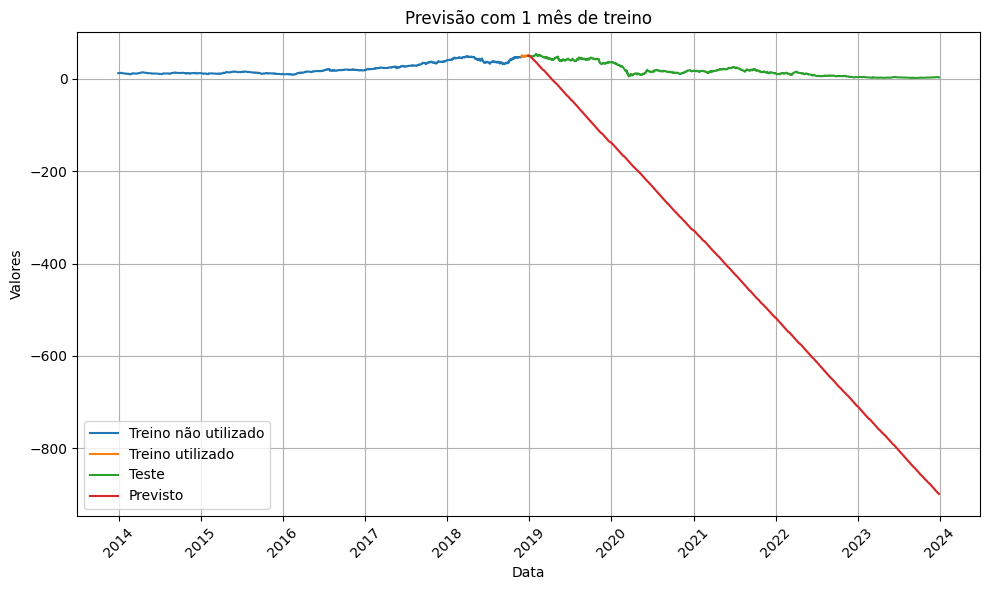

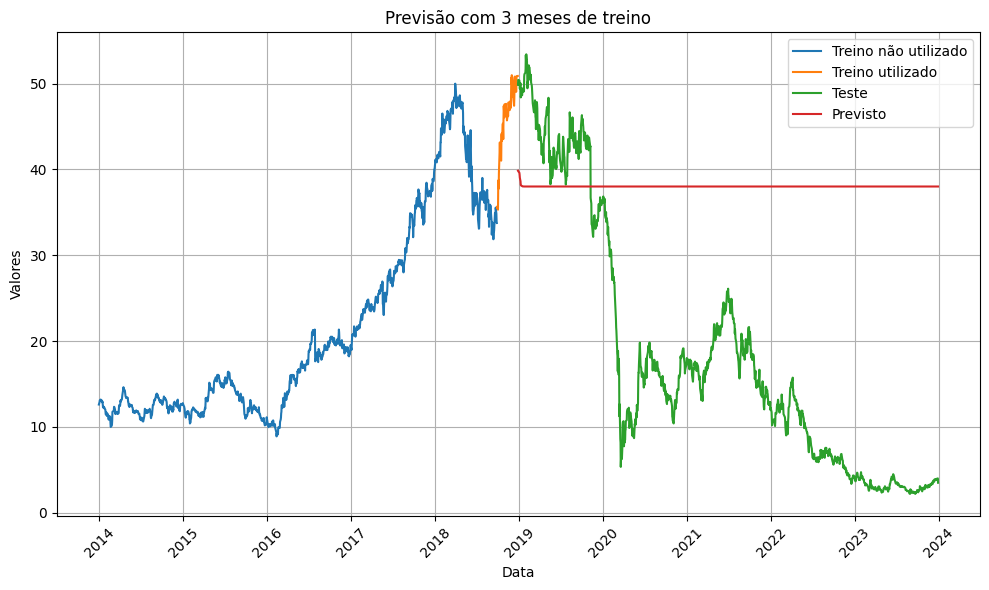

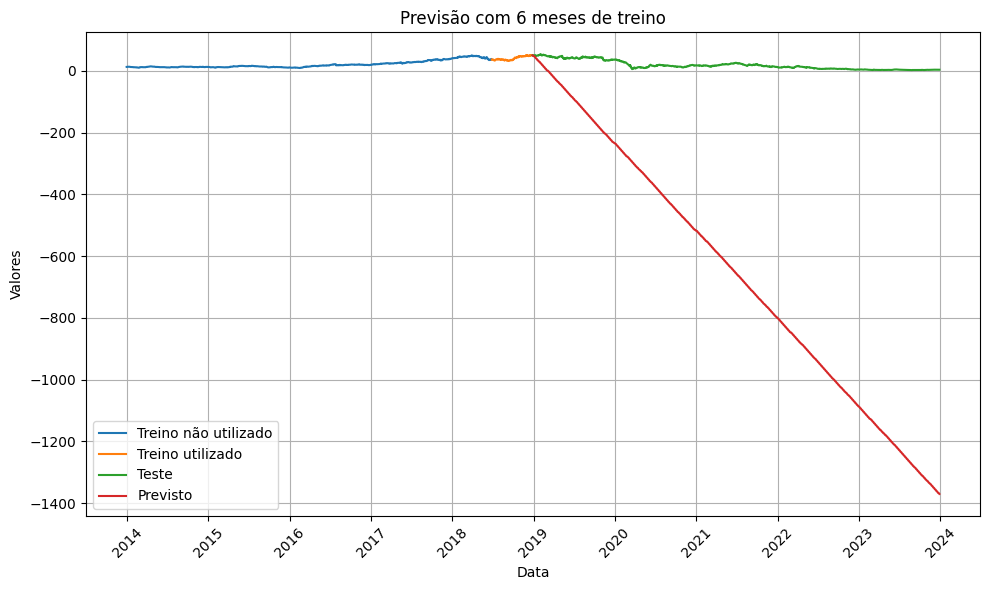

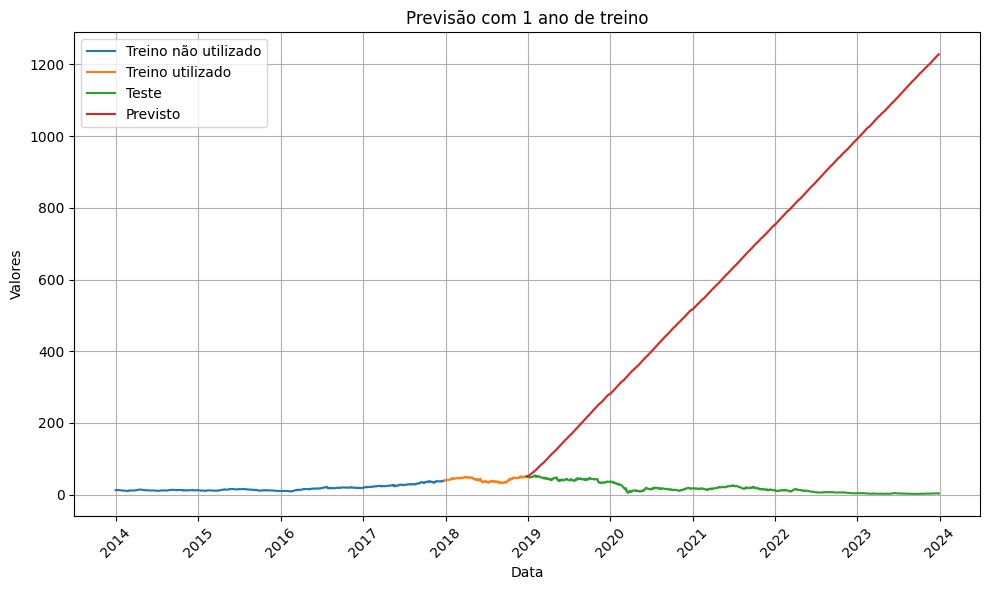

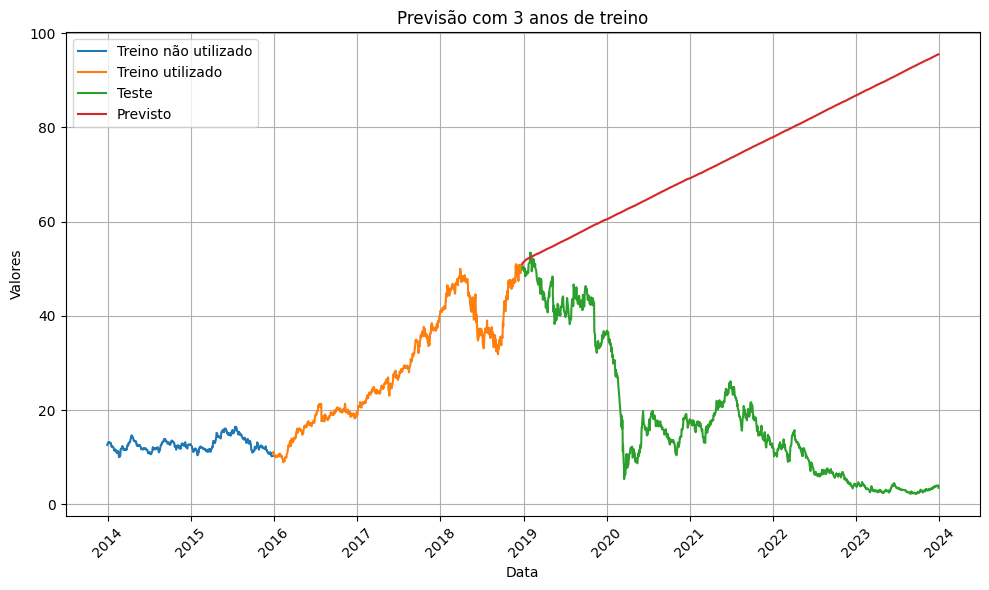

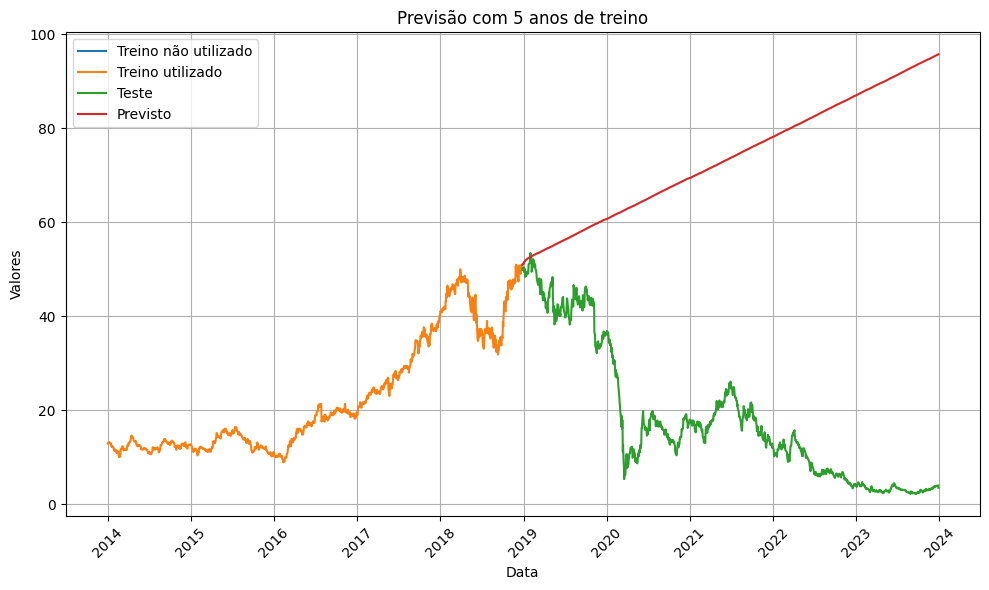

In [35]:
plot_first_ticker_model_results(dict_lstm_pred_results, dict_train_periods, dict_test_history, dict_train_history)

### Método ingênuo

In [38]:
def predizer_precos_com_ingenuo(train_history, n_pred):
    last_price = train_history["CloseEstacionarioNormalizado"].iloc[-1]
    return np.full(n_pred, last_price)

def predizer_todas_as_acoes_com_ingenuo(dict_train_periods, dict_test_history):
    dict_pred = dict()
    progress = 0    
    for periodo, dict_tickers in dict_train_periods.items():
        if not dict_pred.__contains__(periodo):
            dict_pred[periodo] = dict()
        for ticker_name, dict_ticker_details in dict_tickers.items():
            progress += 1
            print(f"Progresso: {progress} - {ticker_name} | Período treinamento: {periodo}")
            test_history = dict_test_history[ticker_name]
            if not dict_pred[periodo].__contains__(ticker_name):
                train_history=dict_ticker_details["history"]
                lst_pred = predizer_precos_com_ingenuo(train_history=train_history, n_pred=len(test_history))
                
                lst_pred_revertido = inverse_normalization(lst_pred, scaler=dict_ticker_details["scaler_normalizacao"])
                lst_pred_revertido = inverse_differencing(train_history, pred_differentiated_series=lst_pred_revertido, num_diffs=dict_ticker_details["num_diffs"])
                
                dict_pred[periodo][ticker_name] =pd.DataFrame({'PredCloseEstacionarioNormalizado': lst_pred, "PredCloseRevertido": lst_pred_revertido}, index=test_history.index)           
    return dict_pred

dict_ingenuo_pred_results = predizer_todas_as_acoes_com_ingenuo(dict_train_periods, dict_test_history)

Progresso: 1 - CVCB3.SA | Período treinamento: 1 mês
Progresso: 2 - EMBR3.SA | Período treinamento: 1 mês
Progresso: 3 - ITSA4.SA | Período treinamento: 1 mês
Progresso: 4 - PETR4.SA | Período treinamento: 1 mês
Progresso: 5 - CIEL3.SA | Período treinamento: 1 mês
Progresso: 6 - B3SA3.SA | Período treinamento: 1 mês
Progresso: 7 - VALE3.SA | Período treinamento: 1 mês
Progresso: 8 - ABEV3.SA | Período treinamento: 1 mês
Progresso: 9 - BBDC4.SA | Período treinamento: 1 mês
Progresso: 10 - COGN3.SA | Período treinamento: 1 mês
Progresso: 11 - GFSA3.SA | Período treinamento: 1 mês
Progresso: 12 - MRVE3.SA | Período treinamento: 1 mês
Progresso: 13 - CMIG4.SA | Período treinamento: 1 mês
Progresso: 14 - MGLU3.SA | Período treinamento: 1 mês
Progresso: 15 - ITUB4.SA | Período treinamento: 1 mês
Progresso: 16 - TRPL4.SA | Período treinamento: 1 mês
Progresso: 17 - PETR3.SA | Período treinamento: 1 mês
Progresso: 18 - LREN3.SA | Período treinamento: 1 mês
Progresso: 19 - BBAS3.SA | Período tr

In [39]:
show_first_ticker_pred_results(dict_ingenuo_pred_results)

Período: 1 mês


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.507866,50.901947
2018-12-28 00:00:00+00:00,0.507866,50.918430
2019-01-02 00:00:00+00:00,0.507866,50.934914
2019-01-03 00:00:00+00:00,0.507866,50.951397
2019-01-04 00:00:00+00:00,0.507866,50.967880



Período: 3 meses


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.994213,50.885464
2018-12-28 00:00:00+00:00,0.994213,50.885464
2019-01-02 00:00:00+00:00,0.994213,50.885464
2019-01-03 00:00:00+00:00,0.994213,50.885464
2019-01-04 00:00:00+00:00,0.994213,50.885464



Período: 6 meses


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.405405,50.901947
2018-12-28 00:00:00+00:00,0.405405,50.918430
2019-01-02 00:00:00+00:00,0.405405,50.934914
2019-01-03 00:00:00+00:00,0.405405,50.951397
2019-01-04 00:00:00+00:00,0.405405,50.967880



Período: 1 ano


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.517147,50.901947
2018-12-28 00:00:00+00:00,0.517147,50.918430
2019-01-02 00:00:00+00:00,0.517147,50.934914
2019-01-03 00:00:00+00:00,0.517147,50.951397
2019-01-04 00:00:00+00:00,0.517147,50.967880



Período: 3 anos


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.517147,50.901947
2018-12-28 00:00:00+00:00,0.517147,50.918430
2019-01-02 00:00:00+00:00,0.517147,50.934914
2019-01-03 00:00:00+00:00,0.517147,50.951397
2019-01-04 00:00:00+00:00,0.517147,50.967880



Período: 5 anos


,PredCloseEstacionarioNormalizado,PredCloseRevertido
Date,,
2018-12-27 00:00:00+00:00,0.517147,50.901947
2018-12-28 00:00:00+00:00,0.517147,50.918430
2019-01-02 00:00:00+00:00,0.517147,50.934914
2019-01-03 00:00:00+00:00,0.517147,50.951397
2019-01-04 00:00:00+00:00,0.517147,50.967880


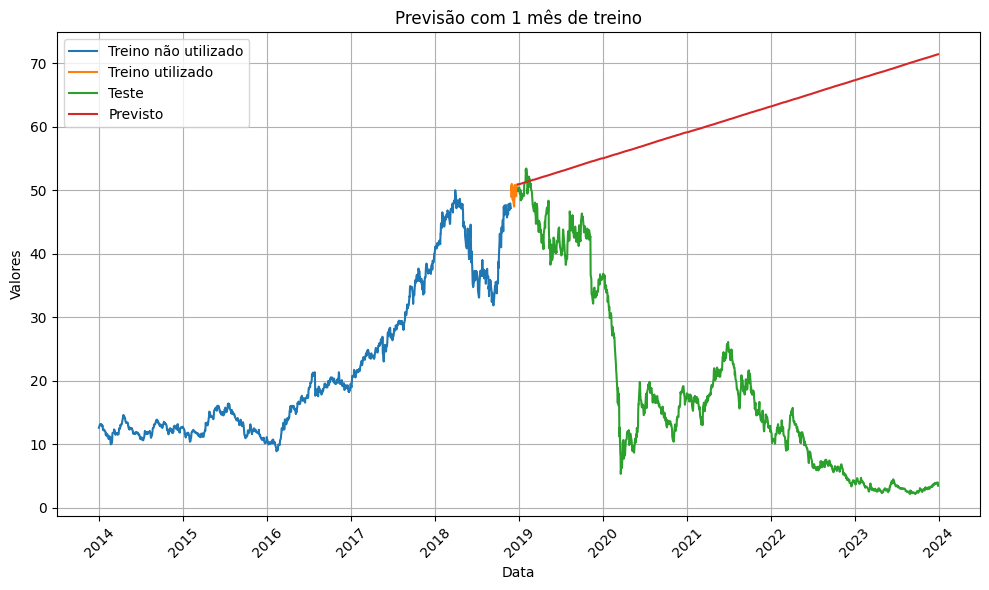

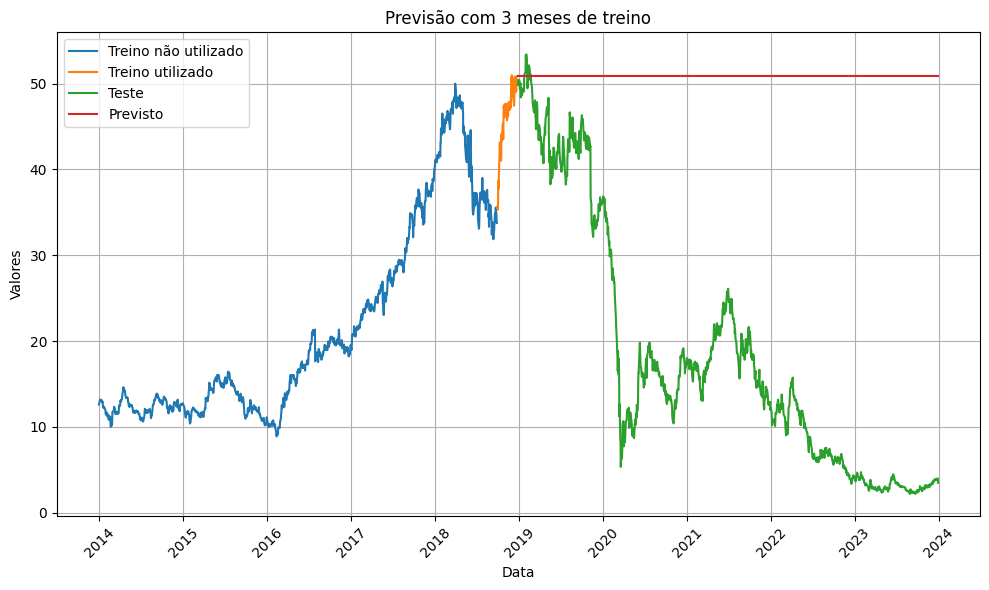

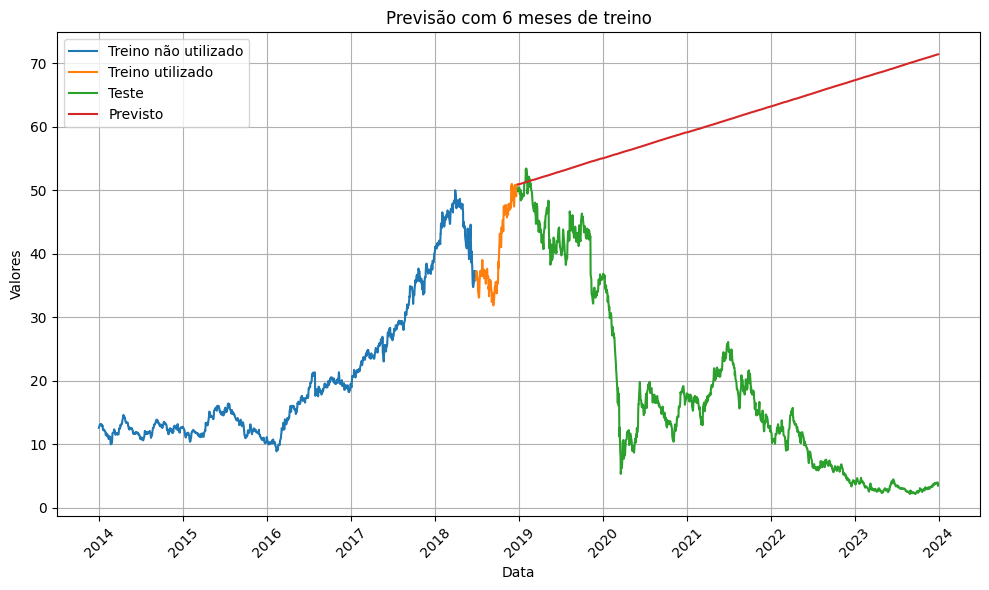

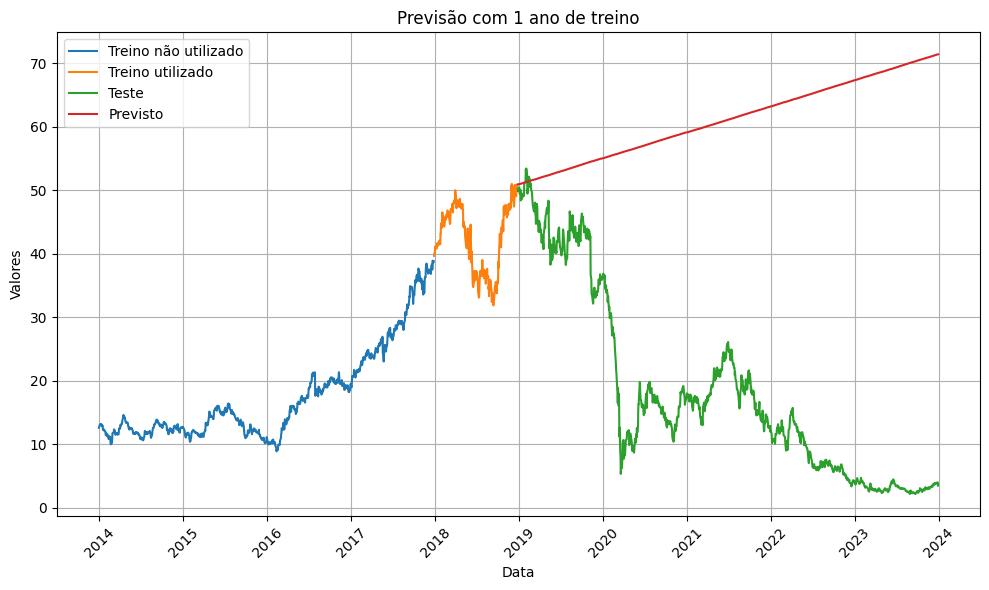

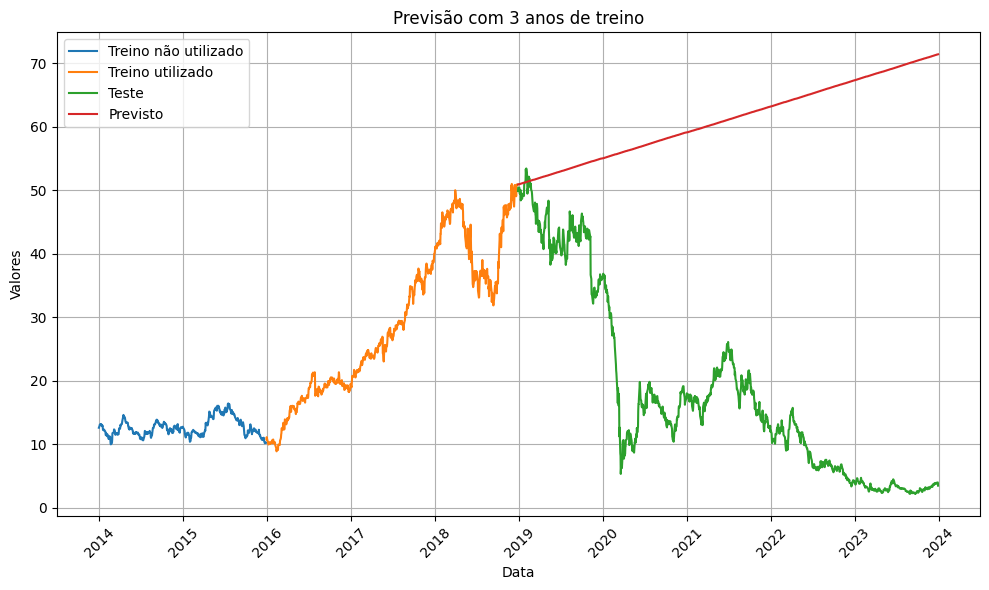

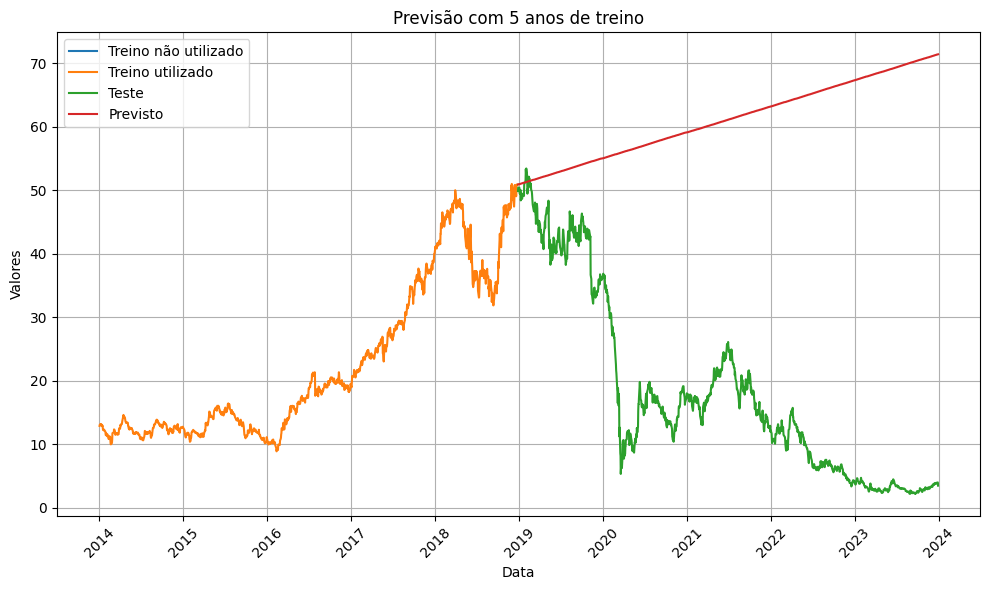

In [40]:
plot_first_ticker_model_results(dict_ingenuo_pred_results, dict_train_periods, dict_test_history, dict_train_history)

### Analisando resultados

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


def separar_test_em_periodos(history: dict) -> dict:
    h2 = {
        "1 mês": dict(),
        "3 meses": dict(),
        "6 meses": dict(),
        "1 ano": dict(),
        "3 anos": dict(),
        "5 anos": dict()
    }
    for ticker, h in history.items():
        min_date = h.index.min()
        h2["1 mês"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=1))
        h2["3 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=3))
        h2["6 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=6))
        h2["1 ano"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=1))
        h2["3 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=3))
        h2["5 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=5))
    return h2


def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                h = test_history[ticker_name]
                h = h.loc[h.index.isin(test_history[ticker_name].index)]
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(h), y_pred=y_pred[:len(h)]) * 100
    return dict_mape


def calculate_mape_means(dict_pred_results, test_history):
    dict_mape_means = dict()
    for periodo, dict_modelo in calculate_mapes(dict_pred_results, test_history).items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means


def mostrar_grafico_mapes(dict_pred_results, test_history):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    for periodo, test in separar_test_em_periodos(test_history).items():
        dict_mape_means = calculate_mape_means(dict_pred_results, test)
        periodos = list(dict_mape_means.keys())
        arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
        lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
        
        # Configurações do gráfico
        bar_width = 0.35
        index = np.arange(len(periodos))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Criar as barras
        ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
        ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
        
        # Título e labels
        ax.set_xlabel('Períodos de treinamento')
        ax.set_ylabel('MAPE médio (%)')
        ax.set_title(f'Comparação entre ARIMA, LSTM e método ingênuo por Período de treinamento prevendo {periodo}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(periodos)
        ax.legend()
        
        # Exibir o gráfico
        plt.tight_layout()
        plt.show()
        
mostrar_grafico_mapes(dict_pred_results, dict_test_history)